### XBOS Anomaly Detection by Yeonho

Cross interaction based outlier score (XBOS) is a cluster-based algorithm for unsupervised anomaly detection. It uses k-means clustering for the first stage, and then calculate cross interaction between clusters as the second stage. Because of this second stage, A small cluster near another large cluster is treated as if that is a middle cluster, so that the data points belong to the cluster is scored 'not so anomalous' as a result.

XBOS assumes independence of the features as same as HBOS. XBOS shows very good performance on Kaggle credit card dataset compared to Isolation Forest and HBOS.

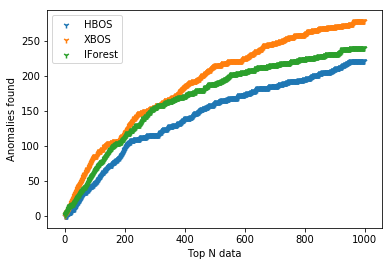

#### XBOS is a really simple algorithm and implemented in just 55 lines of Python code.

In [2]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from pandas import DataFrame
from math import pow
import math

In [5]:
train_data = pd.read_csv('C:/Users/sarah/Desktop/github/open/train.csv')
print(train_data.head(2))

   ID        V1        V2        V3        V4        V5        V6        V7  \
0   3 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
1   4 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
1  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   

        V26       V27       V28       V29       V30  
0 -0.139097 -0.055353 -0.059752  4.983721 -0.994972  
1 -0.221929  0.062723  0.061458  1.418291 -0.994972  

[2 rows x 31 columns]


In [11]:
##구현(Implement)

class XBOS:
    
    def __init__(self,n_clusters=15,effectiveness=500,max_iter=2):
        self.n_clusters=n_clusters
        self.effectiveness=effectiveness
        self.max_iter=max_iter
        self.kmeans = {}
        self.cluster_score = {}
        
    def fit(self, data):
        length = len(data)
        for column in data.columns:
            kmeans = KMeans(n_clusters=self.n_clusters,max_iter=self.max_iter)
            self.kmeans[column]=kmeans
            kmeans.fit(data[column].values.reshape(-1,1))
            assign = DataFrame(kmeans.predict(data[column].values.reshape(-1,1)),columns=['cluster'])
            cluster_score=assign.groupby('cluster').apply(len).apply(lambda x:x/length)
            ratio=cluster_score.copy()
        
            sorted_centers = sorted(kmeans.cluster_centers_)
            max_distance = ( sorted_centers[-1] - sorted_centers[0] )[ 0 ]
        
            for i in range(self.n_clusters):
                for k in range(self.n_clusters):
                    if i != k:
                        dist = abs(kmeans.cluster_centers_[i] - kmeans.cluster_centers_[k])/max_distance
                        effect = ratio[k]*(1/pow(self.effectiveness,dist))
                        cluster_score[i] = cluster_score[i]+effect
                        
            self.cluster_score[column] = cluster_score
                    
    def predict(self, data):
        length = len(data)
        score_array = np.zeros(length)
        for column in data.columns:
            kmeans = self.kmeans[column]
            cluster_score = self.cluster_score[column]
            
            assign = kmeans.predict(data[column].values.reshape(-1,1))
            #print(assign)
            
            for i in range(length):
                score_array[i] = score_array[i] + math.log10(cluster_score[assign[i]])
            
        return score_array
    
    def fit_predict(self,data):
        self.fit(data)
        return self.predict(data)

In [8]:
train_data = pd.read_csv('C:/Users/sarah/Desktop/github/open/train.csv')
train_data = train_data.drop(columns=['ID'])
valid_data = pd.read_csv('C:/Users/sarah/Desktop/github/open/val.csv')
valid_data = valid_data.drop(columns=['ID'])

print(train_data.head(2))
print(valid_data.head(2))

         V1        V2        V3        V4        V5        V6        V7  \
0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0  0.247676 -1.514654  0.207643  ...  0.247998  0.771679  0.909412 -0.689281   
1  0.377436 -1.387024 -0.054952  ... -0.108300  0.005274 -0.190321 -1.175575   

        V25       V26       V27       V28       V29       V30  
0 -0.327642 -0.139097 -0.055353 -0.059752  4.983721 -0.994972  
1  0.647376 -0.221929  0.062723  0.061458  1.418291 -0.994972  

[2 rows x 30 columns]
         V1        V2        V3        V4        V5        V6        V7  \
0 -0.338262  1.119593  1.044367 -0.222187  0.499361 -0.246761  0.651583   
1  0.962496  0.328461 -0.171479  2.109204  1.129566  1.696038  0.107712   

         V8        V9       V10  ...       V22       V23       V24       V25  \
0  0.069539 

In [12]:
xbos = XBOS(n_clusters=15,max_iter=1)
xbos.fit(train_data)



xbos_result_val = xbos.predict(valid_data)

valid_data_copy = valid_data.copy()
valid_data_copy['xbos'] = xbos_result_val
valid_data_copy = valid_data_copy.reset_index()
valid_data_sort = valid_data_copy.sort_values(by = 'xbos', ascending = True)
valid_data_sort['Class'] = 0
valid_data_sort['Class'][:30] = 1
valid_data_sort = valid_data_sort.sort_values(by = 'index', ascending = True)
val_score = f1_score(valid_class, valid_data_sort['Class'], average='macro')
val_score

KeyError: 'Class'

In [14]:
val_score = f1_score(valid_class, valid_data_sort['Class'], average='macro')
print(val_score)

NameError: name 'f1_score' is not defined